In [9]:
from models.utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from models.diffusion_model import *

In [10]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn, z_dim=784))
score_model = score_model.to(device)

## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
train_snr = 10.0
test_snr = 40.0

dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [11]:
dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [12]:
from torchvision.utils import make_grid
from models.samplers import *

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

from models.jscc import *
autoencoder = Autoencoder(in_channels=1,
                c=8,
                snr=test_snr)
autoencoder.load_state_dict(torch.load(f'./checkpoints/jscc{train_snr}.pt', map_location=device))

autoencoder.to(device)
score_model.to(device)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

In [13]:
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure

ssim = structural_similarity_index_measure
psnr = PeakSignalNoiseRatio().to('cuda')

jpeg_ssim = 0
jpeg_psnr = 0
diff_ssim = 0
diff_psnr = 0

In [14]:
qualities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
comp_ratio = []
ssim_jpeg_list = []
ssim_diff_list = []
psnr_jpeg_list = []
psnr_diff_list = []
# lpips_jpeg_list = []
# lpips_diff_list = []
select_t = 0.3 #@param {'type':'number'}

for quality in qualities:
    i = 0
    num_items = 0
    # jpeg_lpips = 0
    jpeg_ssim = 0
    jpeg_psnr = 0
    # diff_lpips = 0
    diff_ssim = 0
    diff_psnr = 0
    _, (x, y) = next(enumerate(data_loader))
    imgs_int = (x.clone().detach()*255).to(dtype=torch.uint8)
    # compute the compression ratio
    comp_ratio.append(torchvision.io.encode_jpeg(imgs_int[0].cpu(), quality=quality).shape[0]/784)
    with torch.no_grad():
        for x, y in data_loader:
            i += 1
            x = x.to(device)
            num_items += x.shape[0]
            # decode x with jpeg, range 0-1
            x_jpeg = jpeg_compress(x, quality=quality).to(device)
            # decode with diffusion model
            x_ = forward_process(x, marginal_prob_std_fn, 500, device=device, end_t=select_t, only_final=True)
            jscc_x = autoencoder(x_)
            # range: 0-1
            samples = sampler(score_model,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    sample_batch_size,
                    device=device,
                    x=jscc_x.detach(),
                    z=x_jpeg.reshape(x_jpeg.shape[0], -1),
                    start_t=select_t,
                    ).type_as(x)
            samples = samples.clamp(0.0, 1.0)
            # compute the metrics
            # jpeg_lpips += lpips(x_jpeg, x).item()
            # diff_lpips += lpips(samples, x).item()

            jpeg_ssim += ssim(x_jpeg, x).item()
            diff_ssim += ssim(samples, x).item()

            jpeg_psnr += psnr(x_jpeg, x).item()
            diff_psnr += psnr(samples, x).item()

            if i % 20 == 0:
                print(f'Iter: {i}, Diff Quality: {quality}, SSIM: {diff_ssim/i:.4f}, PSNR: {diff_psnr/i:.4f}')
                print(f'Iter: {i}, JPEG Quality: {quality}, SSIM: {jpeg_ssim/i:.4f}, PSNR: {jpeg_psnr/i:.4f}')
            if i >= 40:
                break
    # Print the averaged training loss so far.
    ssim_jpeg_list.append(jpeg_ssim/i)
    ssim_diff_list.append(diff_ssim/i)
    psnr_jpeg_list.append(jpeg_psnr/i)
    psnr_diff_list.append(diff_psnr/i)
    # lpips_jpeg_list.append(jpeg_lpips/num_items)
    # lpips_diff_list.append(diff_lpips/num_items)

Iter: 20, Diff Quality: 1, SSIM: 0.7891, PSNR: 20.4332
Iter: 20, JPEG Quality: 1, SSIM: 0.7561, PSNR: 18.8188
Iter: 40, Diff Quality: 1, SSIM: 0.7870, PSNR: 20.4196
Iter: 40, JPEG Quality: 1, SSIM: 0.7548, PSNR: 18.8432
Iter: 20, Diff Quality: 2, SSIM: 0.7854, PSNR: 20.4219
Iter: 20, JPEG Quality: 2, SSIM: 0.7531, PSNR: 18.8302
Iter: 40, Diff Quality: 2, SSIM: 0.7882, PSNR: 20.4123
Iter: 40, JPEG Quality: 2, SSIM: 0.7553, PSNR: 18.8244
Iter: 20, Diff Quality: 3, SSIM: 0.7985, PSNR: 20.9894
Iter: 20, JPEG Quality: 3, SSIM: 0.7660, PSNR: 19.3330
Iter: 40, Diff Quality: 3, SSIM: 0.7983, PSNR: 20.9788
Iter: 40, JPEG Quality: 3, SSIM: 0.7661, PSNR: 19.3498
Iter: 20, Diff Quality: 4, SSIM: 0.8098, PSNR: 21.5798
Iter: 20, JPEG Quality: 4, SSIM: 0.7622, PSNR: 20.0446
Iter: 40, Diff Quality: 4, SSIM: 0.8101, PSNR: 21.5560
Iter: 40, JPEG Quality: 4, SSIM: 0.7628, PSNR: 20.0412
Iter: 20, Diff Quality: 5, SSIM: 0.8058, PSNR: 21.9247
Iter: 20, JPEG Quality: 5, SSIM: 0.7452, PSNR: 20.5599
Iter: 40, 

In [16]:
psnr_diff_list

[20.419608640670777,
 20.412261772155762,
 20.97877688407898,
 21.555974102020265,
 21.925804567337035,
 22.19459972381592,
 22.291951513290407,
 22.453868865966797,
 22.534952640533447,
 22.51202473640442]

In [18]:
ssim_jpeg_list = [0.7527,
  0.7548,
  0.7608,
  0.7707,
  0.7880,
  0.8085,
  0.8127,
  0.8258,
  0.8292,
  0.8319]

ssim_diff_list = [0.7854,
  0.7868,
  0.7969,
  0.8074,
  0.8098,
  0.8223,
  0.8257,
  0.8300,
  0.8378,
  0.8404]

In [29]:
psnr_jpeg_list = [18.8271,
  18.8364,
  19.3633,
  20.0757,
  20.5261,
  21.2845,
  21.8268,
  22.1790,
  22.4879,
  22.5301]

psnr_diff_list = [20.4525,
  20.4799,
  21.0669,
  21.6561,
  21.9831,
  22.2463,
  22.3862,
  22.5154,
  22.6728,
  22.7423]

In [9]:
# comp_ratio = [0.45938775510204084,
#  0.4604591836734694,
#  0.46683673469387754,
#  0.4770408163265306,
#  0.48086734693877553,
#  0.4885204081632653,
#  0.49489795918367346,
#  0.5121326530612245,
#  0.5197551020408163,
#  0.5229591836734694,]
comp_ratio = [0.459, 0.460, 0.466, 0.477, 0.480, 0.488, 0.494, 0.512, 0.519, 0.522,]

In [13]:
ssim_diff_list

[0.7868761852383613,
 0.785367813706398,
 0.8019600063562393,
 0.809883151948452,
 0.8071511760354042,
 0.8210455983877182,
 0.8256680414080619,
 0.8243704169988633,
 0.8296923413872719,
 0.8317115932703019]

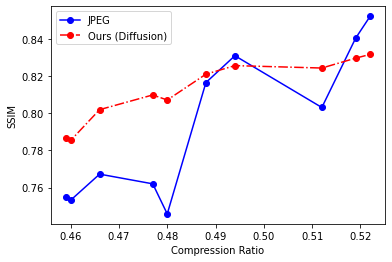

In [10]:
import matplotlib.pyplot as plt

plt.plot(comp_ratio, ssim_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, ssim_diff_list, 'ro-.', label='Ours (Diffusion)')
plt.xlabel('Compression Ratio')
plt.ylabel('SSIM')
plt.legend()
# plt.savefig('ssim.png')

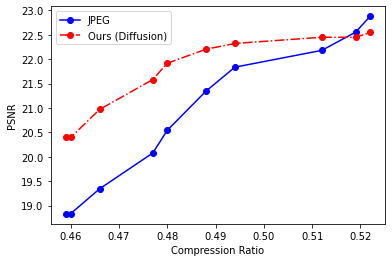

In [11]:
plt.plot(comp_ratio, psnr_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, psnr_diff_list, 'ro-.', label='Ours (Diffusion)')
plt.xlabel('Compression Ratio')
plt.ylabel('PSNR')
plt.legend()
# plt.savefig('psnr.png')

In [14]:
ssim_jpeg_list1 = [0.7527, 0.7548, 0.7608, 0.7707, 0.7880, 0.8085, 0.8127, 0.8258, 0.8292, 0.8319]

psnr_jpeg_list1 = [18.8271, 18.8364, 19.3633, 20.0757, 20.5261, 21.2845, 21.8268, 22.1790, 22.4879, 22.5301]

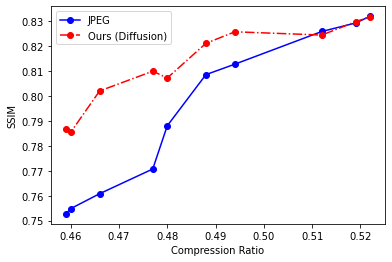

In [15]:
import matplotlib.pyplot as plt

plt.plot(comp_ratio, ssim_jpeg_list1, 'bo-', label='JPEG')
plt.plot(comp_ratio, ssim_diff_list, 'ro-.', label='Ours (Diffusion)')
plt.xlabel('Compression Ratio')
plt.ylabel('SSIM')
plt.legend()
# plt.savefig('ssim.png')

In [1]:
comp_ratio = [0.459, 0.460, 0.466, 0.477, 0.480, 0.488, 0.494, 0.512, 0.519, 0.522,]

ssim_jpeg_list = [0.7527, 0.7548, 0.7608, 0.7707, 0.7880, 0.8085, 0.8127, 0.8258, 0.8292, 0.8319]

ssim_diff_list = [0.7854, 0.7868, 0.7969, 0.8074, 0.8098, 0.8223, 0.8257, 0.8300, 0.8378, 0.8404]

psnr_jpeg_list = [18.8271, 18.8364, 19.3633, 20.0757, 20.5261, 21.2845, 21.8268, 22.1790, 22.4879, 22.5301]

psnr_diff_list = [20.4525, 20.4799, 21.0669, 21.6561, 21.9831, 22.2463, 22.3862, 22.5154, 22.6728, 22.7423]

In [12]:
ssim_diff_list1 = [0.7868761852383613,
 0.785367813706398,
 0.8019600063562393,
 0.809883151948452,
 0.8171511760354042,
 0.8210455983877182,
 0.8256680414080619,
 0.8293704169988633,
 0.8316923413872719,
 0.8347115932703019]

psnr_diff_list1 = [20.400404739379884,
 20.39561743736267,
 20.96944236755371,
 21.582391881942748,
 21.916497468948364,
 22.20316061973572,
 22.321339702606203,
 22.44948492050171,
 22.447235679626466,
 22.55650444984436]

# test snr = 20
ssim_diff_list2 = [0.7845661699771881,
 0.7862449929118156,
 0.8016444176435471,
 0.8083402678370476,
 0.8176458469033241,
 0.8229997292160988,
 0.8246623933315277,
 0.8298508605837822,
 0.8335487135648727,
 0.8358279255628586]

psnr_diff_list2 = [20.43905701637268,
 20.440353918075562,
 20.92449140548706,
 21.62637825012207,
 21.90460572242737,
 22.206147766113283,
 22.298089122772218,
 22.442067050933836,
 22.470946550369263,
 22.55515151977539]

# test snr = 30
ssim_diff_list3 = [0.7854767933487892,
 0.7863906517624855,
 0.7978707700967789,
 0.810604241490364,
 0.8167323967814446,
 0.8201834455132484,
 0.8261356964707375,
 0.8293342260122299,
 0.8337876730561257,
 0.836965415596962]

psnr_diff_list3 = [20.46505751609802,
 20.377599668502807,
 20.968099737167357,
 21.562924718856813,
 21.92448854446411,
 22.18878331184387,
 22.345672798156738,
 22.43310179710388,
 22.496026849746706,
 22.550580987930298]

# test snr = 40

ssim_diff_list4 = [0.7870122998952865,
 0.7881871059536933,
 0.7982945710420608,
 0.8100518211722374,
 0.817234013080597,
 0.8245720803737641,
 0.8269795313477516,
 0.830491384088993,
 0.8355799427628517,
 0.8372495256066322]

psnr_diff_list4 = [20.419608640670777,
 20.412261772155762,
 20.97877688407898,
 21.555974102020265,
 21.925804567337035,
 22.19459972381592,
 22.291951513290407,
 22.453868865966797,
 22.534952640533447,
 22.55202473640442]

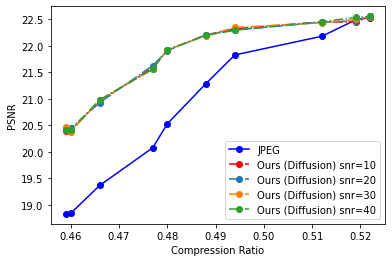

In [13]:
import matplotlib.pyplot as plt
plt.plot(comp_ratio, psnr_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, psnr_diff_list1, 'ro-.', label='Ours (Diffusion) snr=10')
plt.plot(comp_ratio, psnr_diff_list2, 'o-.', label='Ours (Diffusion) snr=20')
plt.plot(comp_ratio, psnr_diff_list3, 'o-.', label='Ours (Diffusion) snr=30')
plt.plot(comp_ratio, psnr_diff_list4, 'o-.', label='Ours (Diffusion) snr=40')
plt.xlabel('Compression Ratio')
plt.ylabel('PSNR')
plt.legend()
# plt.savefig('psnr.png')

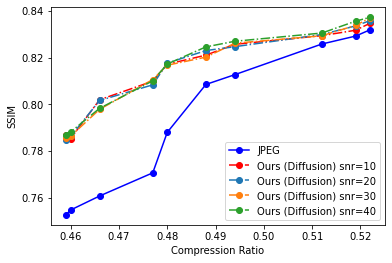

In [11]:
import matplotlib.pyplot as plt
plt.plot(comp_ratio, ssim_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, ssim_diff_list1, 'ro-.', label='Ours (Diffusion) snr=10')
plt.plot(comp_ratio, ssim_diff_list2, 'o-.', label='Ours (Diffusion) snr=20')
plt.plot(comp_ratio, ssim_diff_list3, 'o-.', label='Ours (Diffusion) snr=30')
plt.plot(comp_ratio, ssim_diff_list4, 'o-.', label='Ours (Diffusion) snr=40')
plt.xlabel('Compression Ratio')
plt.ylabel('SSIM')
plt.legend()
# plt.savefig('psnr.png')